#### Setup

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch

import pyciemss
from pyciemss.PetriNetODE.interfaces import setup_model, reset_model, intervene, sample, calibrate, optimize, load_petri_model
import mira
from pyciemss.utils import get_tspan

import warnings
warnings.filterwarnings('ignore')

In [16]:
### Plotting Utils ###

COLORS=['red','green','blue','black','gold']
def plot_trajectories(sol, tspan, data=None):
    fig = plt.figure(facecolor='w', figsize=(6, 6))
    ax = fig.add_subplot(111, axisbelow=True) # setup graph
    d_keys = [list(x[1].keys())[0] for x in data] if data else [] # get affected variables
    
    if len(sol[list(sol.keys())[3]]) == 1: # single trajectory
        for i,var in enumerate(list(sol.keys())[2:]): # skip beta, gamma parameters
            ax.plot(tspan, sol[var].squeeze().detach().numpy(), COLORS[i], alpha=0.5, lw=3, label=var)
            if var[:-4] in d_keys: # there is training data of this variable
                x = np.array([x[0] for x in data if var[:-4] in list(x[1].keys())])
                y = np.array([x[1][var[:-4]] for x in data if var[:-4] in list(x[1].keys())]) # without _sol prefix
                ax.scatter(x,y,label=var[:-4]+" data",color=COLORS[i])
                
    else: # fill between multiple trajectories
        tspan   = torch.as_tensor(tspan)
        indices = torch.ones_like(tspan).bool()
        for i,var in enumerate(list(sol.keys())[2:]):
            I_low = torch.quantile(sol[var], 0.05, dim=0).detach().numpy()
            I_up  = torch.quantile(sol[var], 0.95, dim=0).detach().numpy()
            ax.fill_between(tspan[indices], I_low[indices], I_up[indices], alpha=0.2, color=COLORS[i], label=var)
            if var[:-4] in d_keys: # there is training data of this variable
                x = np.array([x[0] for x in data if var[:-4] in list(x[1].keys())])
                y = np.array([x[1][var[:-4]] for x in data if var[:-4] in list(x[1].keys())]) # without _sol prefix
                ax.scatter(x,y,label=var[:-4]+" data",color=COLORS[i])
    ax.legend()

## SIR MIRA

### Load and show model (prior)

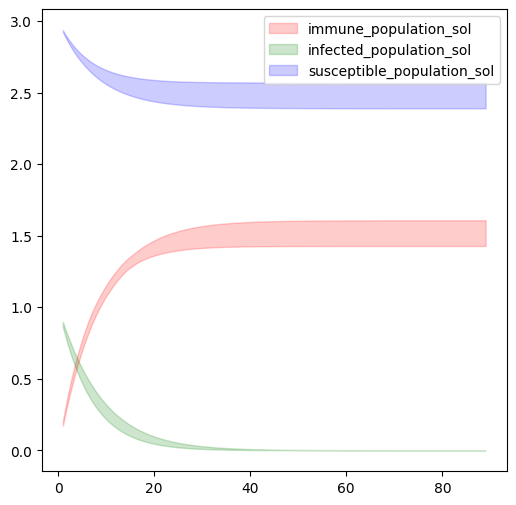

In [17]:
from mira.examples.sir import sir_parameterized as sir
full_tspan = get_tspan(1, 89, 890)
mira_raw   = load_petri_model(sir, add_uncertainty=True)
mira_model = setup_model(mira_raw, start_time=0, start_state=dict(susceptible_population=3.0,
                                                                    infected_population=1.0,
                                                                    immune_population=0.0))
solution = sample(mira_model, timepoints=full_tspan, num_samples=30)

plot_trajectories(solution,full_tspan)
plt.show()

### Calibrate on data (posterior)

iteration 0: loss = 9.24793803691864
iteration 25: loss = 7.632745862007141
iteration 50: loss = 5.502633690834045
iteration 75: loss = 4.995230317115784
iteration 100: loss = 4.098356008529663


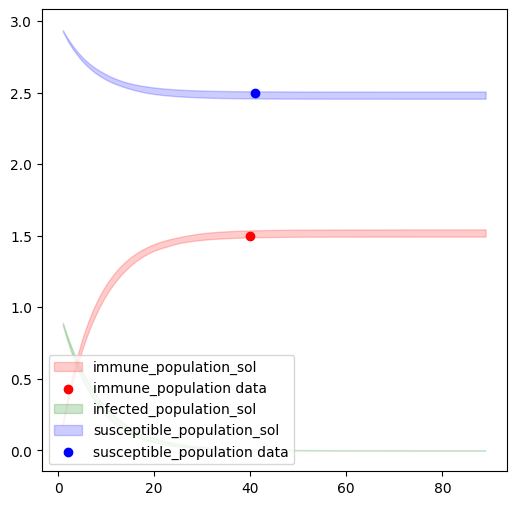

In [23]:
# data in the form list[ tuple(timepoint, dict(variable, observation)) , ...]
data = [(40.0,dict(immune_population  =1.50)),
        (41.0,dict(susceptible_population=2.50))]
infer_mira = calibrate(mira_model,data, num_iterations=101, verbose=True)

calib_solution = sample(mira_model, timepoints=full_tspan, num_samples=30, inferred_parameters=infer_mira)

plot_trajectories(calib_solution,full_tspan,data)
plt.show()

### Intervene

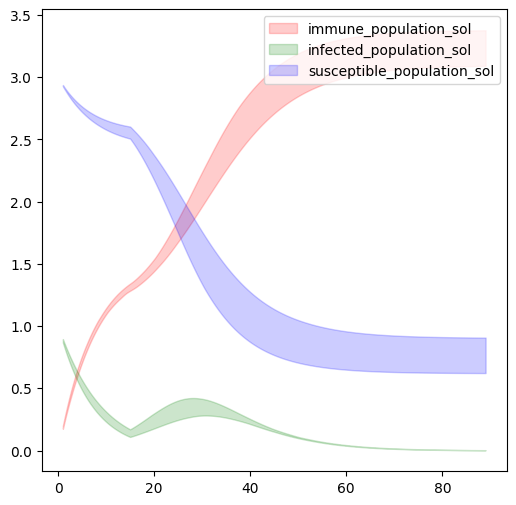

In [29]:
interventions   = [(15.0,"beta",0.5)] # list[ tuple(time, param, value) , ... ]
intervened_mira = intervene(mira_model, interventions)

calib_solution = sample(intervened_mira, timepoints=full_tspan, num_samples=30)

plot_trajectories(calib_solution,full_tspan)
plt.show()

## SIR Handmade

### Load and show model (prior)

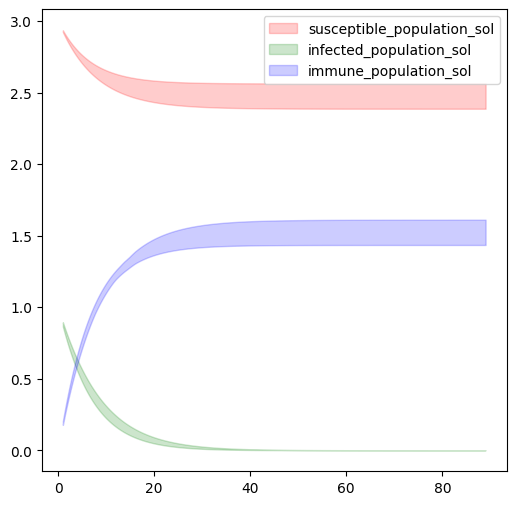

In [24]:
from pyciemss.PetriNetODE.models import SIR_with_uncertainty
from pyro.infer import Predictive
full_tspan = get_tspan(1, 89, 890)
SIR_raw  = SIR_with_uncertainty(N=100.0, beta=0.1, gamma=0.2) # N here unecessary, makes its own
SIR_model = setup_model(SIR_raw, start_time=0, start_state=dict(susceptible_population=3.0,
                                                                  infected_population=1.0,
                                                                  immune_population=0.0))
solution   = sample(SIR_model,full_tspan,30)

plot_trajectories(solution,full_tspan)
plt.show()

### Calibrate on data (posterior)

iteration 0: loss = 8.28907334804535
iteration 25: loss = 6.857364296913147
iteration 50: loss = 5.045287489891052
iteration 75: loss = 4.452529549598694
iteration 100: loss = 4.211421728134155


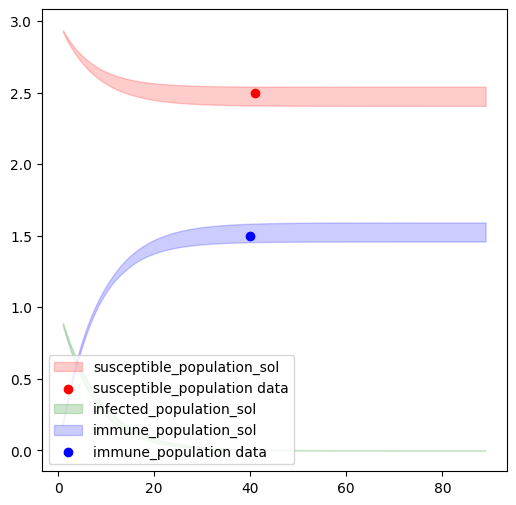

In [26]:
# data in the form list[ tuple(timepoint, dict(variable, observation)) , ...]
data = [(40.0,dict(immune_population  =1.50)),
        (41.0,dict(susceptible_population=2.50))]
infer_SIR = calibrate(SIR_model,data, num_iterations=101, verbose=True)

calib_solution = sample(SIR_model, timepoints=full_tspan, num_samples=30, inferred_parameters=infer_SIR)

plot_trajectories(calib_solution,full_tspan,data)
plt.show()

### Intervene

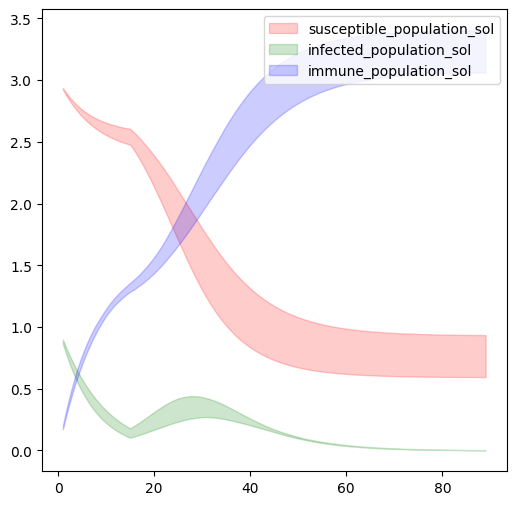

In [31]:
interventions   = [(15.0,"beta",0.5)] # tuple(time, param, value)
intervened_SIR = intervene(SIR_model, interventions)

interv_solution = sample(intervened_SIR, timepoints=full_tspan, num_samples=30)

plot_trajectories(interv_solution,full_tspan)
plt.show()